In [1]:
import pandas as pd
import numpy as np
import random
import copy

In [2]:
seed = 42

In [3]:
data = pd.read_csv('../GeneralData/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [4]:
import torch.nn as nn

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [8]:
device = torch.device("cuda:0")

In [9]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [11]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1148562/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [12]:
torch.cuda.is_available()

True

In [13]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [14]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,11.119,4.153,7.427,1.919,3.746,1.675,32.922001
165,2016-07-07 21:00:00,10.449,3.282,7.107,1.279,3.594,1.706,33.625999
166,2016-07-07 22:00:00,10.516,3.885,7.356,1.599,3.168,1.675,32.640999
167,2016-07-07 23:00:00,11.855,5.358,8.884,3.198,3.076,1.553,31.586000


In [15]:
X_train

tensor([[[  5.8270,   2.0090,   1.5990,  ...,   4.2030,   1.3400,  30.5310],
         [  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         ...,
         [ 10.4490,   3.2820,   7.1070,  ...,   3.5940,   1.7060,  33.6260],
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860]],

        [[  5.6930,   2.0760,   1.4920,  ...,   4.1420,   1.3710,  27.7870],
         [  5.1570,   1.7410,   1.2790,  ...,   3.7770,   1.2180,  27.7870],
         [  5.0900,   1.9420,   1.2790,  ...,   3.8070,   1.2790,  25.0440],
         ...,
         [ 10.5160,   3.8850,   7.3560,  ...,   3.1680,   1.6750,  32.6410],
         [ 11.8550,   5.3580,   8.8840,  ...,   3.0760,   1.5530,  31.5860],
         [ 11.8550,   4.7560,   8.8840,  ...,   2.9550,   1.5230,  31.0930]],

        [[  5.1570,   1.7410,   1.2790,  ...

In [16]:
y_train

tensor([[[31.0930]],

        [[30.7420]],

        [[29.3350]],

        ...,

        [[ 4.2910]],

        [[ 6.2610]],

        [[ 3.9390]]], device='cuda:0')

In [17]:
from torch.optim import Adam

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = LSTM().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [19]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 299.998
changed
Epoch [2]/[200] running accumulative loss across all batches: 293.345
changed
Epoch [3]/[200] running accumulative loss across all batches: 283.591
changed
Epoch [4]/[200] running accumulative loss across all batches: 271.459
changed
Epoch [5]/[200] running accumulative loss across all batches: 258.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 245.469
changed
Epoch [7]/[200] running accumulative loss across all batches: 234.679
changed
Epoch [8]/[200] running accumulative loss across all batches: 225.510
changed
Epoch [9]/[200] running accumulative loss across all batches: 217.436
changed
Epoch [10]/[200] running accumulative loss across all batches: 210.248
changed
Epoch [11]/[200] running accumulative loss across all batches: 203.722
changed
Epoch [12]/[200] running accumulative loss across all batches: 197.630
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [106]/[200] running accumulative loss across all batches: 23.435
changed
Epoch [107]/[200] running accumulative loss across all batches: 23.049
changed
Epoch [108]/[200] running accumulative loss across all batches: 22.671
changed
Epoch [109]/[200] running accumulative loss across all batches: 22.301
changed
Epoch [110]/[200] running accumulative loss across all batches: 21.940
changed
Epoch [111]/[200] running accumulative loss across all batches: 21.586
changed
Epoch [112]/[200] running accumulative loss across all batches: 21.239
changed
Epoch [113]/[200] running accumulative loss across all batches: 20.900
changed
Epoch [114]/[200] running accumulative loss across all batches: 20.567
changed
Epoch [115]/[200] running accumulative loss across all batches: 20.242
changed
Epoch [116]/[200] running accumulative loss across all batches: 19.922
changed
Epoch [117]/[200] running accumulative loss across all batches: 19.610
changed
Epoch [118]/[200] running accumulative loss across a

In [21]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [22]:
for val in validation:
    print(val[0].size())

torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])


In [23]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 168, 7])

In [24]:
ig = IntegratedGradients(model)
attr_score = ig.attribute(test,return_convergence_delta=True)
attr_score

(tensor([[[ 7.2795e-06,  6.1833e-06,  1.0780e-07,  ..., -8.7178e-06,
            5.8044e-06, -1.7340e-05],
          [ 5.9985e-06,  4.8340e-06,  6.0547e-06,  ..., -1.2217e-05,
            1.6179e-06, -1.0400e-05],
          [ 3.3266e-06,  3.7779e-06,  7.9729e-06,  ..., -1.2421e-05,
            1.5212e-06, -9.2704e-06],
          ...,
          [-1.5672e-01, -5.6650e-02,  8.3364e-01,  ..., -3.1919e-01,
           -3.0626e-02,  3.0587e-02],
          [ 5.0480e-02, -2.3200e-01,  1.0255e+00,  ..., -1.4223e-01,
           -1.1559e-02,  3.4585e-01],
          [ 7.5000e-01, -2.4765e-01, -1.1786e+00,  ...,  4.9105e-01,
           -9.7863e-02,  3.5517e+00]]], device='cuda:0', dtype=torch.float64),
 tensor([-4.2184e-07], device='cuda:0', dtype=torch.float64))

In [25]:
attr_score[0].size()

torch.Size([1, 168, 7])

In [26]:
delta = attr_score[1]

In [27]:
attr_score = attr_score[0]

In [28]:
attr_score.to("cpu")

tensor([[[ 7.2795e-06,  6.1833e-06,  1.0780e-07,  ..., -8.7178e-06,
           5.8044e-06, -1.7340e-05],
         [ 5.9985e-06,  4.8340e-06,  6.0547e-06,  ..., -1.2217e-05,
           1.6179e-06, -1.0400e-05],
         [ 3.3266e-06,  3.7779e-06,  7.9729e-06,  ..., -1.2421e-05,
           1.5212e-06, -9.2704e-06],
         ...,
         [-1.5672e-01, -5.6650e-02,  8.3364e-01,  ..., -3.1919e-01,
          -3.0626e-02,  3.0587e-02],
         [ 5.0480e-02, -2.3200e-01,  1.0255e+00,  ..., -1.4223e-01,
          -1.1559e-02,  3.4585e-01],
         [ 7.5000e-01, -2.4765e-01, -1.1786e+00,  ...,  4.9105e-01,
          -9.7863e-02,  3.5517e+00]]], dtype=torch.float64)

In [29]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[ 7.27946294e-06,  6.18329540e-06,  1.07804897e-07, ...,
         -8.71778966e-06,  5.80435712e-06, -1.73397251e-05],
        [ 5.99845781e-06,  4.83401888e-06,  6.05473321e-06, ...,
         -1.22168449e-05,  1.61786184e-06, -1.04004627e-05],
        [ 3.32659169e-06,  3.77789859e-06,  7.97285480e-06, ...,
         -1.24206807e-05,  1.52124493e-06, -9.27041976e-06],
        ...,
        [-1.56718455e-01, -5.66504632e-02,  8.33642792e-01, ...,
         -3.19186644e-01, -3.06264542e-02,  3.05872281e-02],
        [ 5.04803877e-02, -2.32004522e-01,  1.02546276e+00, ...,
         -1.42230756e-01, -1.15590152e-02,  3.45846561e-01],
        [ 7.50001424e-01, -2.47650251e-01, -1.17862638e+00, ...,
          4.91045561e-01, -9.78628999e-02,  3.55169980e+00]]])

In [30]:
plot_attribution = plot_attribution.reshape(-1,7)

In [31]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [32]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [33]:
attr_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,7.279463e-06,0.000006,1.078049e-07,0.000009,-0.000009,5.804357e-06,-0.000017
1,5.998458e-06,0.000005,6.054733e-06,0.000004,-0.000012,1.617862e-06,-0.000010
2,3.326592e-06,0.000004,7.972855e-06,0.000003,-0.000012,1.521245e-06,-0.000009
3,-2.944322e-06,0.000003,9.133870e-06,0.000002,-0.000010,-3.350724e-08,-0.000005
4,2.695831e-07,0.000004,7.546096e-06,0.000001,-0.000011,-1.448393e-07,-0.000004
...,...,...,...,...,...,...,...
163,-1.679156e-01,0.001354,6.702499e-01,-0.031586,-0.361791,-3.993744e-02,-0.066121
164,-2.417698e-01,-0.011250,8.250063e-01,-0.036049,-0.332986,-3.084385e-02,-0.047876
165,-1.567185e-01,-0.056650,8.336428e-01,-0.038598,-0.319187,-3.062645e-02,0.030587
166,5.048039e-02,-0.232005,1.025463e+00,-0.037175,-0.142231,-1.155902e-02,0.345847


# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [34]:
next(iter(validation))[1][0]

tensor([[3.4470]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [35]:
attr_df.sum(axis=0).sum()

3.5755725456904917

1. delta가 attribution 유의미하게 작은지 확인
2. baseline vector 넣었을떄 0인지

### 1의 답

In [36]:
delta

tensor([-4.2184e-07], device='cuda:0', dtype=torch.float64)

In [37]:
test_baseline = torch.FloatTensor(np.zeros((1,sequence_length,7)))
base_pred = model(test_baseline)
base_pred

tensor([[-0.4740]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 2의 답

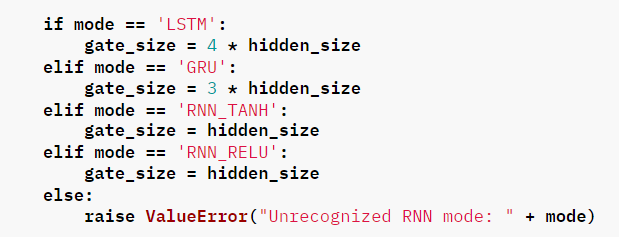
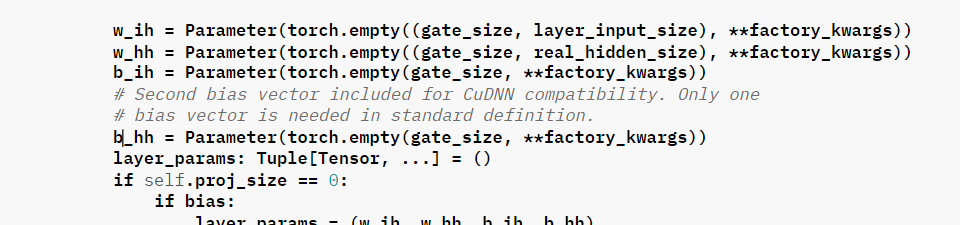

<font color = blue><font size = 5> what is CuDNN Compatibility?</font></font>

https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html

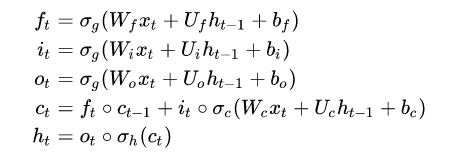

* **LSTM의 bias는 4개가 존재하고 따라서 4*hiddensize만큼의 bias element갯수가 존재한다.**

In [56]:
bias1 = model.encoder.bias_hh_l0
bias1

Parameter containing:
tensor([ 0.1710,  0.0439,  0.3144, -0.0021, -0.0252,  0.1300, -0.0585,  0.3216,
        -0.0514,  0.2664,  0.2211,  0.0895,  0.0987, -0.0208, -0.3302, -0.0123,
        -0.0796,  0.0348,  0.0932, -0.2107, -0.0843,  0.0701,  0.0333,  0.0098,
         0.0101,  0.0396, -0.0135, -0.2678, -0.1596,  0.2393, -0.1882, -0.2287,
         0.2262,  0.2909,  0.0064,  0.1542, -0.0166, -0.5002,  0.1158,  0.2509,
         0.0273,  0.0863, -0.0974,  0.4300,  0.3866,  0.1752,  0.4716,  0.2127,
         0.0010,  0.1220,  0.1059,  0.1752, -0.2231,  0.3103,  0.2604, -0.2521],
       device='cuda:0', requires_grad=True)

In [57]:
bias1.sum(axis=0)

tensor(3.1737, device='cuda:0', grad_fn=<SumBackward1>)

In [58]:
model.encoder.bias_hh_l0.size()

torch.Size([56])

In [59]:
bias2 = model.encoder.bias_ih_l0
bias2

Parameter containing:
tensor([ 0.2479,  0.0631,  0.3179,  0.1004,  0.0562,  0.1122, -0.3207, -0.1092,
         0.1218,  0.1716,  0.1662,  0.0992, -0.0419,  0.1239, -0.1718,  0.2307,
         0.2527, -0.1963, -0.0821, -0.1618, -0.1821, -0.0083,  0.0920, -0.3007,
        -0.0666, -0.2170, -0.1764,  0.2200, -0.3214, -0.1735,  0.0977, -0.0714,
         0.1692,  0.2431,  0.4011, -0.2023,  0.1894, -0.0124, -0.0363,  0.4103,
         0.3078, -0.0037,  0.2600,  0.1513, -0.0743,  0.0954,  0.5060, -0.0500,
         0.3240, -0.0395,  0.3614,  0.5827,  0.0471, -0.0372,  0.2091,  0.0362],
       device='cuda:0', requires_grad=True)

In [60]:
bias2.sum(axis = 0)

tensor(3.7101, device='cuda:0', grad_fn=<SumBackward1>)

## 전체 피쳐의 평균 영향
* 각 피쳐가 미치는 영향도를 구할 수 있음

<AxesSubplot: >

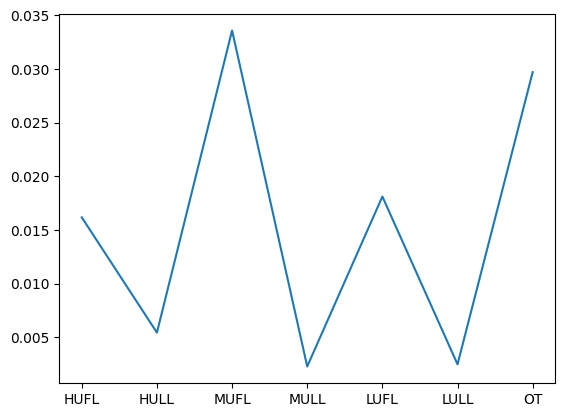

In [41]:
attr_df.abs().mean(axis=0).plot()

## 각 시간 별 영향 추이
* 각 시간별로 중요한 정도를 계산할 수 있음

<AxesSubplot: >

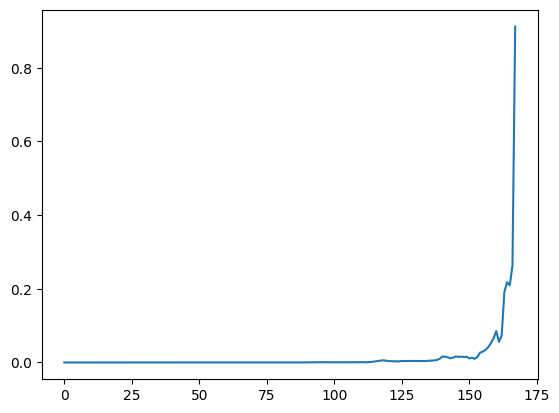

In [42]:
attr_df.abs().mean(axis = 1).plot()

## 각 피쳐별로 시간에 따른 영향 추이

<AxesSubplot: >

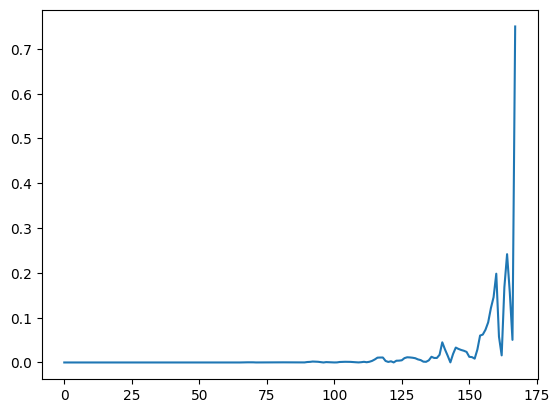

In [43]:
attr_df['HUFL'].abs().plot()

<AxesSubplot: >

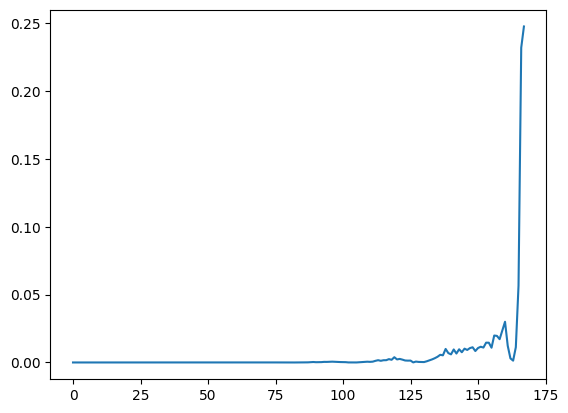

In [44]:
attr_df['HULL'].abs().plot()

<AxesSubplot: >

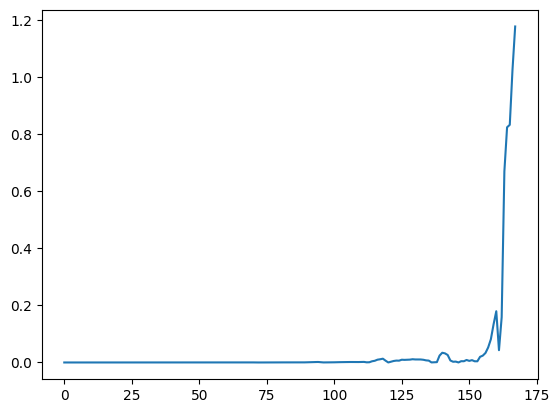

In [45]:
attr_df['MUFL'].abs().plot()

<AxesSubplot: >

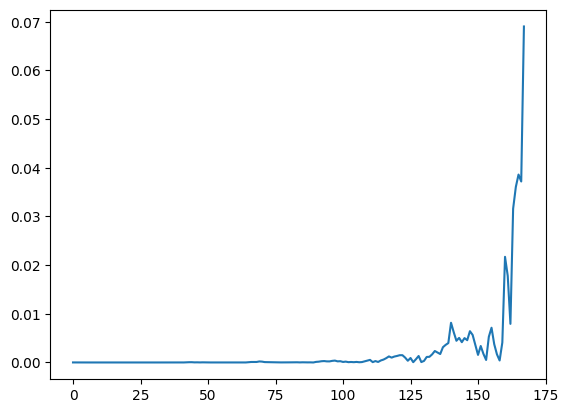

In [46]:
attr_df['MULL'].abs().plot()

<AxesSubplot: >

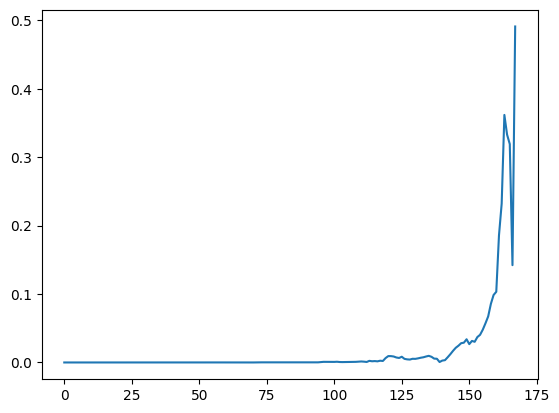

In [47]:
attr_df['LUFL'].abs().plot()

<AxesSubplot: >

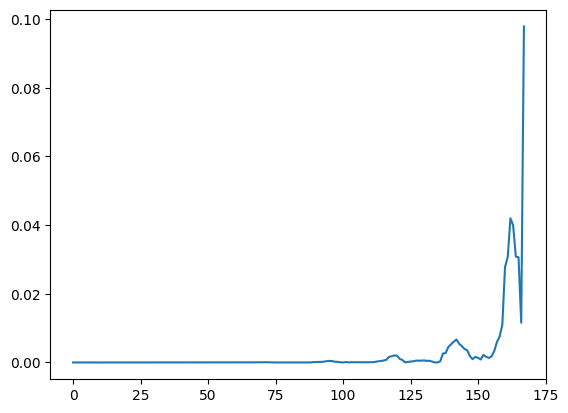

In [48]:
attr_df['LULL'].abs().plot()

<AxesSubplot: >

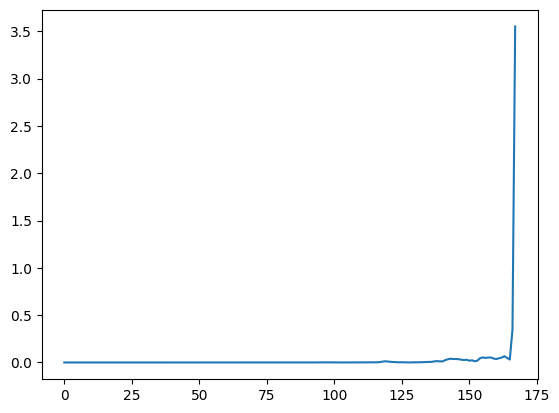

In [49]:
attr_df['OT'].abs().plot()

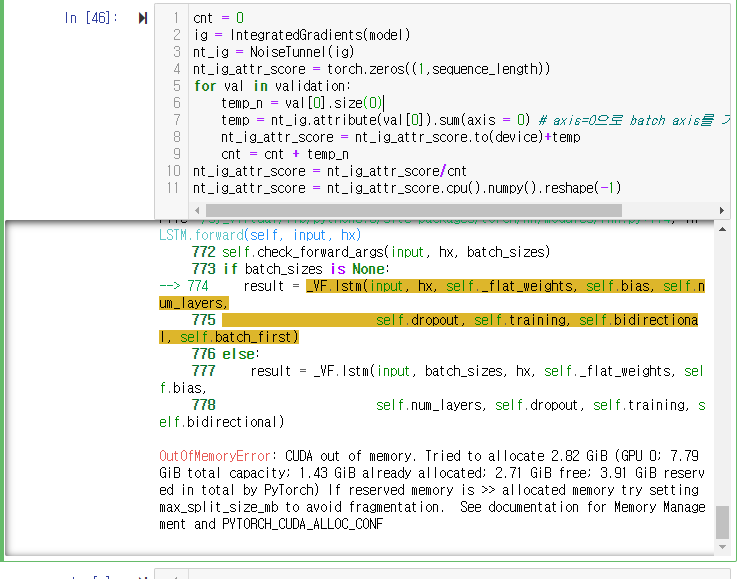

In [50]:
sequence_length

168

In [51]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((1,sequence_length))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.to("cpu").detach().numpy().reshape(-1,feature_size)
        temp = temp.sum(axis=1) 
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [52]:
ig_attr_score.reshape(-1)

array([2.22416230e-05, 2.06636336e-05, 1.87121261e-05, 1.76882523e-05,
       1.72636531e-05, 1.69996229e-05, 1.68117274e-05, 1.68391405e-05,
       1.66385654e-05, 1.65187802e-05, 1.67644015e-05, 1.69694355e-05,
       1.74477844e-05, 1.78849118e-05, 1.84890398e-05, 1.89728509e-05,
       1.98177862e-05, 2.09240614e-05, 2.18692185e-05, 2.30347668e-05,
       2.40268124e-05, 2.50213626e-05, 2.61047946e-05, 2.68159968e-05,
       2.75025670e-05, 2.84848263e-05, 2.85912454e-05, 2.88567510e-05,
       2.88962950e-05, 2.88943677e-05, 2.89740308e-05, 2.90261534e-05,
       2.95427006e-05, 2.99661875e-05, 3.03646909e-05, 3.09485050e-05,
       3.10609632e-05, 3.14120060e-05, 3.20423955e-05, 3.30900065e-05,
       3.45676665e-05, 3.64870522e-05, 3.89328018e-05, 4.15253964e-05,
       4.42193714e-05, 4.73834250e-05, 5.05200435e-05, 5.30441348e-05,
       5.53808808e-05, 5.77063833e-05, 5.88370046e-05, 5.96948884e-05,
       6.12357357e-05, 6.29603724e-05, 6.46603076e-05, 6.71492173e-05,
      

<AxesSubplot: >

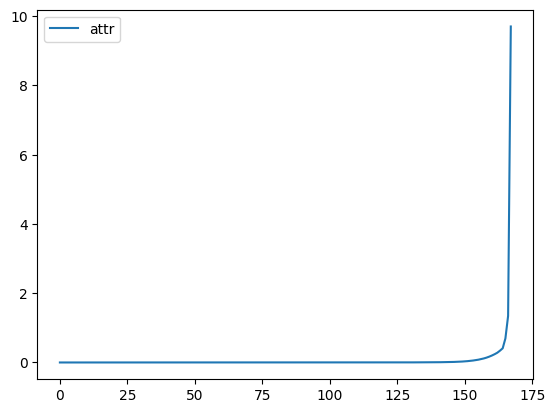

In [53]:
total_mean_attr_df = pd.DataFrame({"attr":ig_attr_score.reshape(-1)})
total_mean_attr_df.plot()

In [55]:
for val_batch in validation:
    print(val_batch[0])
    for val in val_batch[0]:
        print(val)

tensor([[[  3.6840,   2.2100,  -0.7110,  ...,   4.1120,   0.9440,   3.7990],
         [ 13.3290,   2.7460,   8.4930,  ...,   4.7210,   0.8220,   3.5880],
         [ 15.6060,   2.9470,  10.2700,  ...,   5.2390,   0.9140,   3.7990],
         ...,
         [-12.3910,   2.2770, -16.1330,  ...,   3.0760,   0.7610,   2.8840],
         [-11.1190,   2.9470, -14.2500,  ...,   2.8330,   0.6700,   3.9390],
         [ -6.0950,   1.7410,  -9.7010,  ...,   2.9240,   0.7010,   3.5880]],

        [[ 13.3290,   2.7460,   8.4930,  ...,   4.7210,   0.8220,   3.5880],
         [ 15.6060,   2.9470,  10.2700,  ...,   5.2390,   0.9140,   3.7990],
         [ 18.6870,   3.8180,  12.9350,  ...,   5.7570,   0.8220,   3.5880],
         ...,
         [-11.1190,   2.9470, -14.2500,  ...,   2.8330,   0.6700,   3.9390],
         [ -6.0950,   1.7410,  -9.7010,  ...,   2.9240,   0.7010,   3.5880],
         [  4.0190,   0.9380,   1.1370,  ...,   3.1680,   0.6090,   3.4470]],

        [[ 15.6060,   2.9470,  10.2700,  ...

tensor([[17.0800,  5.0900, 14.0360,  ...,  3.4110,  0.7310,  3.9390],
        [16.4770,  4.2870, 13.6810,  ...,  3.0150,  0.6400,  4.2210],
        [15.3380,  4.1530, 12.7220,  ...,  2.6500,  0.5180,  3.7990],
        ...,
        [17.4150,  3.0140, 12.7220,  ...,  4.7820,  0.5790,  3.7990],
        [15.3380,  2.4780, 11.3360,  ...,  3.9600,  0.5180,  3.7990],
        [12.5920,  1.9420,  9.3810,  ...,  3.2590,  0.5180,  4.1500]],
       device='cuda:0')
tensor([[16.4770,  4.2870, 13.6810,  ...,  3.0150,  0.6400,  4.2210],
        [15.3380,  4.1530, 12.7220,  ...,  2.6500,  0.5180,  3.7990],
        [14.6020,  4.2870, 11.9400,  ...,  2.6800,  0.5180,  3.5170],
        ...,
        [15.3380,  2.4780, 11.3360,  ...,  3.9600,  0.5180,  3.7990],
        [12.5920,  1.9420,  9.3810,  ...,  3.2590,  0.5180,  4.1500],
        [10.3820,  1.4740,  7.7110,  ...,  2.6800,  0.4870,  4.2910]],
       device='cuda:0')
tensor([[15.3380,  4.1530, 12.7220,  ...,  2.6500,  0.5180,  3.7990],
        [14.60

tensor([[ 9.9800,  2.4110,  8.3150,  ...,  2.1320,  0.7010,  4.7130],
        [10.7170,  1.8750,  8.1020,  ...,  2.3450,  0.6700,  4.6430],
        [11.2530,  2.0090,  8.3860,  ...,  2.6190,  0.5790,  3.0950],
        ...,
        [ 8.3720,  1.0050,  5.8990,  ...,  2.4370,  0.4570,  4.0100],
        [ 7.5020,  1.0050,  5.2950,  ...,  2.2240,  0.4570,  4.1500],
        [ 6.9660,  0.8040,  4.8330,  ...,  2.0710,  0.4570,  4.9950]],
       device='cuda:0')
tensor([[10.7170,  1.8750,  8.1020,  ...,  2.3450,  0.6700,  4.6430],
        [11.2530,  2.0090,  8.3860,  ...,  2.6190,  0.5790,  3.0950],
        [13.3960,  2.7460, 10.3050,  ...,  3.4720,  0.6400,  2.8140],
        ...,
        [ 7.5020,  1.0050,  5.2950,  ...,  2.2240,  0.4570,  4.1500],
        [ 6.9660,  0.8040,  4.8330,  ...,  2.0710,  0.4570,  4.9950],
        [ 6.8320,  0.8040,  4.7620,  ...,  2.0710,  0.4260,  4.3620]],
       device='cuda:0')
tensor([[11.2530,  2.0090,  8.3860,  ...,  2.6190,  0.5790,  3.0950],
        [13.39

tensor([[ 6.0280,  0.8710,  3.3760,  ...,  2.4980,  0.5180,  7.3860],
        [ 6.8990,  0.8710,  4.1930,  ...,  2.6500,  0.5180,  7.4570],
        [ 9.6450,  1.2060,  6.4670,  ...,  3.1980,  0.5480,  7.4570],
        ...,
        [ 6.9660,  1.0050,  3.2690,  ...,  3.7160,  0.5480,  2.8840],
        [ 8.6400,  1.3400,  5.0100,  ...,  3.5330,  0.6090,  2.6030],
        [11.1860,  1.6080,  7.3910,  ...,  3.8070,  0.6090,  2.7440]],
       device='cuda:0')
tensor([[ 6.8990,  0.8710,  4.1930,  ...,  2.6500,  0.5180,  7.4570],
        [ 9.6450,  1.2060,  6.4670,  ...,  3.1980,  0.5480,  7.4570],
        [12.2570,  1.5410,  8.3510,  ...,  3.8680,  0.5180,  7.4570],
        ...,
        [ 8.6400,  1.3400,  5.0100,  ...,  3.5330,  0.6090,  2.6030],
        [11.1860,  1.6080,  7.3910,  ...,  3.8070,  0.6090,  2.7440],
        [11.4540,  1.4740,  7.6400,  ...,  3.7460,  0.5790,  2.5320]],
       device='cuda:0')
tensor([[ 9.6450,  1.2060,  6.4670,  ...,  3.1980,  0.5480,  7.4570],
        [12.25

tensor([[16.9460,  2.5450, 11.7270,  ...,  5.2080,  0.5790,  2.6730],
        [17.2140,  2.7460, 11.8330,  ...,  5.3300,  0.6090,  2.6030],
        [15.9410,  2.2100, 11.0510,  ...,  4.8430,  0.5480,  2.2510],
        ...,
        [ 6.3630,  1.1390,  3.8380,  ...,  2.7110,  0.7310,  4.8540],
        [ 9.2430,  1.0720,  5.9340,  ...,  3.5640,  0.8530,  5.5570],
        [ 9.4440,  0.4690,  6.4320,  ...,  2.9550,  0.5180,  5.9790]],
       device='cuda:0')
tensor([[17.2140,  2.7460, 11.8330,  ...,  5.3300,  0.6090,  2.6030],
        [15.9410,  2.2100, 11.0510,  ...,  4.8430,  0.5480,  2.2510],
        [14.2000,  2.0760,  9.9500,  ...,  4.2340,  0.4870,  2.0400],
        ...,
        [ 9.2430,  1.0720,  5.9340,  ...,  3.5640,  0.8530,  5.5570],
        [ 9.4440,  0.4690,  6.4320,  ...,  2.9550,  0.5180,  5.9790],
        [11.3200,  0.6030,  7.8530,  ...,  3.5030,  0.4570,  4.9950]],
       device='cuda:0')
tensor([[15.9410,  2.2100, 11.0510,  ...,  4.8430,  0.5480,  2.2510],
        [14.20

tensor([[ 9.3770,  1.0720,  6.7520,  ...,  2.5590,  0.4260,  5.6980],
        [ 8.0380,  0.9380,  5.8280,  ...,  2.1630,  0.4260,  4.9950],
        [ 7.1000,  0.9380,  5.1530,  ...,  1.9490,  0.4570,  4.9950],
        ...,
        [12.5920,  0.8040,  9.4170,  ...,  3.1370,  0.5480,  2.1100],
        [11.3200,  1.5410,  8.9550,  ...,  2.5890,  0.4870,  2.3210],
        [10.6500,  1.4070,  8.2800,  ...,  2.2540,  0.4570,  2.6730]],
       device='cuda:0')
tensor([[ 8.0380,  0.9380,  5.8280,  ...,  2.1630,  0.4260,  4.9950],
        [ 7.1000,  0.9380,  5.1530,  ...,  1.9490,  0.4570,  4.9950],
        [ 6.8320,  0.9380,  4.9390,  ...,  1.9190,  0.4570,  5.2760],
        ...,
        [11.3200,  1.5410,  8.9550,  ...,  2.5890,  0.4870,  2.3210],
        [10.6500,  1.4070,  8.2800,  ...,  2.2540,  0.4570,  2.6730],
        [ 9.9800,  1.2060,  7.7820,  ...,  1.8580,  0.4260,  2.1810]],
       device='cuda:0')
tensor([[ 7.1000,  0.9380,  5.1530,  ...,  1.9490,  0.4570,  4.9950],
        [ 6.83

tensor([[-10.3820,   0.3350, -12.4370,  ...,   2.3760,   0.7920,   5.3460],
        [-16.0750,   1.8750, -19.1530,  ...,   2.8630,   0.6700,   5.3460],
        [-11.9890,   1.1390, -14.0010,  ...,   1.9190,   0.6700,   6.3310],
        ...,
        [ 12.2570,   1.5410,   6.3610,  ...,   6.0610,   1.2790,   1.9700],
        [  3.8180,   1.1390,  -2.5230,  ...,   6.3960,   1.9190,   1.4070],
        [ -7.4350,   1.8750, -10.6250,  ...,   2.8940,   1.2490,   1.4070]],
       device='cuda:0')
tensor([[-16.0750,   1.8750, -19.1530,  ...,   2.8630,   0.6700,   5.3460],
        [-11.9890,   1.1390, -14.0010,  ...,   1.9190,   0.6700,   6.3310],
        [ -2.4780,  -0.4020,  -4.3710,  ...,   2.1630,   0.8530,   7.4570],
        ...,
        [  3.8180,   1.1390,  -2.5230,  ...,   6.3960,   1.9190,   1.4070],
        [ -7.4350,   1.8750, -10.6250,  ...,   2.8940,   1.2490,   1.4070],
        [ -8.7740,   1.9420, -11.6910,  ...,   2.9550,   1.0360,   2.1810]],
       device='cuda:0')
tensor([[-11

tensor([[ -2.3440,   1.0720,  -5.3300,  ...,   2.2240,   0.7610,   7.6680],
        [ -0.1340,  -0.0670,  -3.4110,  ...,   2.1020,   0.6090,   7.5270],
        [  5.8940,   0.3350,   1.7770,  ...,   3.1370,   0.6400,   7.4570],
        ...,
        [-17.6830,   3.3490, -21.3210,  ...,   2.5890,   0.9750,   6.5420],
        [-18.0180,   4.1530, -20.3970,  ...,   2.4980,   0.9440,   7.2460],
        [-16.6780,   3.6170, -19.9710,  ...,   2.3450,   1.0360,   9.3560]],
       device='cuda:0')
tensor([[ -0.1340,  -0.0670,  -3.4110,  ...,   2.1020,   0.6090,   7.5270],
        [  5.8940,   0.3350,   1.7770,  ...,   3.1370,   0.6400,   7.4570],
        [  8.1050,   0.5360,   5.3660,  ...,   2.8630,   0.6400,   6.9640],
        ...,
        [-18.0180,   4.1530, -20.3970,  ...,   2.4980,   0.9440,   7.2460],
        [-16.6780,   3.6170, -19.9710,  ...,   2.3450,   1.0360,   9.3560],
        [-11.3870,   3.1480, -16.5950,  ...,   4.9650,   1.2180,   8.5120]],
       device='cuda:0')
tensor([[  5

tensor([[12.3240,  3.2150,  7.5690,  ...,  4.6600,  1.1270,  2.5320],
        [11.3870,  3.6170,  7.3200,  ...,  4.3860,  1.0360,  2.7440],
        [11.8550,  2.5450,  6.6450,  ...,  4.7820,  1.0970,  4.2210],
        ...,
        [11.0520,  3.8850,  8.2800,  ...,  2.4670,  0.8220,  9.5670],
        [10.2480,  3.6170,  8.2090,  ...,  2.0710,  0.7310,  9.4260],
        [12.8600,  4.7560,  8.7420,  ...,  4.5380,  1.1270,  9.7080]],
       device='cuda:0')
tensor([[11.3870,  3.6170,  7.3200,  ...,  4.3860,  1.0360,  2.7440],
        [11.8550,  2.5450,  6.6450,  ...,  4.7820,  1.0970,  4.2210],
        [11.1190,  3.4160,  6.0760,  ...,  5.0560,  1.2790,  3.7990],
        ...,
        [10.2480,  3.6170,  8.2090,  ...,  2.0710,  0.7310,  9.4260],
        [12.8600,  4.7560,  8.7420,  ...,  4.5380,  1.1270,  9.7080],
        [14.6690,  5.0900,  9.8430,  ...,  4.8130,  1.4320,  9.7080]],
       device='cuda:0')
tensor([[11.8550,  2.5450,  6.6450,  ...,  4.7820,  1.0970,  4.2210],
        [11.11

tensor([[12.5920,  3.2150,  8.0660,  ...,  5.2080,  1.4920,  7.6680],
        [14.4010,  4.4880,  7.8890,  ...,  5.8790,  1.2790,  7.4570],
        [ 3.0140,  3.1480, -0.3200,  ...,  3.0760,  0.9440,  8.0200],
        ...,
        [10.8510,  3.5500,  8.6710,  ...,  1.9190,  0.6400,  4.8540],
        [14.2000,  6.1620, 11.8690,  ...,  2.1020,  0.6400,  4.7840],
        [14.5350,  6.0950, 12.1530,  ...,  2.3760,  0.7920,  4.3620]],
       device='cuda:0')
tensor([[14.4010,  4.4880,  7.8890,  ...,  5.8790,  1.2790,  7.4570],
        [ 3.0140,  3.1480, -0.3200,  ...,  3.0760,  0.9440,  8.0200],
        [-6.7650,  1.8080, -9.2040,  ...,  2.8940,  1.0660,  8.3010],
        ...,
        [14.2000,  6.1620, 11.8690,  ...,  2.1020,  0.6400,  4.7840],
        [14.5350,  6.0950, 12.1530,  ...,  2.3760,  0.7920,  4.3620],
        [13.1280,  4.2200, 10.4120,  ...,  2.7110,  0.6700,  5.8390]],
       device='cuda:0')
tensor([[  3.0140,   3.1480,  -0.3200,  ...,   3.0760,   0.9440,   8.0200],
        

tensor([[  4.7560,   2.1430,   1.9540,  ...,   3.2900,   0.8530,   3.0250],
        [  4.8230,   2.2770,   2.2740,  ...,   3.0760,   1.0360,   3.6580],
        [  4.8900,   1.6740,   2.1320,  ...,   2.8020,   0.9440,   4.0100],
        ...,
        [  4.0190,   3.6170,   0.3200,  ...,   3.4720,   1.3710,   8.5820],
        [ -6.0280,   2.4110,  -9.3810,  ...,   3.1680,   1.3100,   8.2310],
        [-11.9220,   3.4160, -15.3160,  ...,   2.9550,   0.9440,   9.9190]],
       device='cuda:0')
tensor([[  4.8230,   2.2770,   2.2740,  ...,   3.0760,   1.0360,   3.6580],
        [  4.8900,   1.6740,   2.1320,  ...,   2.8020,   0.9440,   4.0100],
        [  3.8850,   1.3400,   1.3860,  ...,   2.5280,   0.9440,   3.7990],
        ...,
        [ -6.0280,   2.4110,  -9.3810,  ...,   3.1680,   1.3100,   8.2310],
        [-11.9220,   3.4160, -15.3160,  ...,   2.9550,   0.9440,   9.9190],
        [-14.3340,   4.0860, -17.5900,  ...,   3.0460,   0.7920,   9.9890]],
       device='cuda:0')
tensor([[  4

tensor([[ 7.7030,  1.8080,  4.7260,  ...,  2.7720,  0.8830,  2.6030],
        [ 7.8370,  2.6790,  5.6860,  ...,  2.3150,  0.6700,  3.3770],
        [13.3960,  4.4880, 11.1940,  ...,  2.4670,  0.6090,  3.3770],
        ...,
        [ 6.2960,  1.8080,  3.6250,  ...,  2.6800,  0.7920, 12.8740],
        [ 7.6360,  2.1430,  4.8680,  ...,  3.2290,  0.7920, 11.5370],
        [ 7.5690,  1.4070,  4.5130,  ...,  3.1370,  0.7610, 10.8330]],
       device='cuda:0')
tensor([[ 7.8370,  2.6790,  5.6860,  ...,  2.3150,  0.6700,  3.3770],
        [13.3960,  4.4880, 11.1940,  ...,  2.4670,  0.6090,  3.3770],
        [12.3240,  5.2240, 10.4830,  ...,  1.9190,  0.5180,  3.4470],
        ...,
        [ 7.6360,  2.1430,  4.8680,  ...,  3.2290,  0.7920, 11.5370],
        [ 7.5690,  1.4070,  4.5130,  ...,  3.1370,  0.7610, 10.8330],
        [ 8.7740,  2.0760,  5.9340,  ...,  3.0460,  0.9440, 10.4820]],
       device='cuda:0')
tensor([[13.3960,  4.4880, 11.1940,  ...,  2.4670,  0.6090,  3.3770],
        [12.32

tensor([[13.9320,  5.2240,  9.3460,  ...,  4.5690,  1.2180,  9.2860],
        [15.1370,  5.8270,  9.3100,  ...,  4.3560,  1.2180, 10.5520],
        [12.2570,  4.4880,  8.1730,  ...,  4.5690,  0.8530, 10.3410],
        ...,
        [15.4720,  5.8270, 10.8740,  ...,  4.4470,  1.1880,  5.7680],
        [17.2810,  7.3010, 12.7930,  ...,  4.3560,  1.1270,  9.0040],
        [13.9320,  5.4250,  9.5590,  ...,  4.2950,  1.0970,  9.2150]],
       device='cuda:0')
tensor([[15.1370,  5.8270,  9.3100,  ...,  4.3560,  1.2180, 10.5520],
        [12.2570,  4.4880,  8.1730,  ...,  4.5690,  0.8530, 10.3410],
        [10.2480,  4.0860,  7.3910,  ...,  2.6800,  0.9750, 10.6930],
        ...,
        [17.2810,  7.3010, 12.7930,  ...,  4.3560,  1.1270,  9.0040],
        [13.9320,  5.4250,  9.5590,  ...,  4.2950,  1.0970,  9.2150],
        [14.5350,  5.5590, 10.3050,  ...,  4.2340,  1.1880,  9.0040]],
       device='cuda:0')
tensor([[12.2570,  4.4880,  8.1730,  ...,  4.5690,  0.8530, 10.3410],
        [10.24

tensor([[-18.0850,   4.5550, -20.8950,  ...,   2.2540,   0.9440,   9.1450],
        [-16.4770,   4.4880, -18.6560,  ...,   2.1630,   1.0360,   9.6380],
        [ -6.6310,   3.1480,  -8.1730,  ...,   2.1630,   1.0360,  10.1300],
        ...,
        [  8.2390,   1.1390,   4.9390,  ...,   2.9550,   0.9140,   0.4220],
        [  8.3060,   1.7410,   5.1530,  ...,   3.1370,   0.9750,   0.0000],
        [  7.6360,   2.0760,   4.4420,  ...,   3.3810,   0.7920,  -0.6330]],
       device='cuda:0')
tensor([[-16.4770,   4.4880, -18.6560,  ...,   2.1630,   1.0360,   9.6380],
        [ -6.6310,   3.1480,  -8.1730,  ...,   2.1630,   1.0360,  10.1300],
        [  0.9380,   3.1480,  -1.3150,  ...,   2.1930,   0.9440,  10.6930],
        ...,
        [  8.3060,   1.7410,   5.1530,  ...,   3.1370,   0.9750,   0.0000],
        [  7.6360,   2.0760,   4.4420,  ...,   3.3810,   0.7920,  -0.6330],
        [  4.6220,   1.1390,   1.8480,  ...,   2.6500,   0.7610,  -0.7030]],
       device='cuda:0')
tensor([[-6.

tensor([[  4.6220,   2.2100,   0.9590,  ...,   3.4420,   1.1270,  12.0290],
        [  6.6310,   1.8080,   3.6960,  ...,   2.9550,   0.8830,  11.2560],
        [  7.7030,   1.6080,   4.7620,  ...,   2.7110,   0.7920,  10.9740],
        ...,
        [-15.1370,   1.4740, -17.8390,  ...,   2.6190,   1.1570,  11.3260],
        [-11.2530,   1.0720, -14.2140,  ...,   2.5890,   1.2180,  10.9040],
        [ -7.9040,  -0.3350,  -9.8080,  ...,   2.0100,   0.8830,  12.1000]],
       device='cuda:0')
tensor([[  6.6310,   1.8080,   3.6960,  ...,   2.9550,   0.8830,  11.2560],
        [  7.7030,   1.6080,   4.7620,  ...,   2.7110,   0.7920,  10.9740],
        [  7.7030,   1.6740,   4.6200,  ...,   3.0150,   0.8530,  10.5520],
        ...,
        [-11.2530,   1.0720, -14.2140,  ...,   2.5890,   1.2180,  10.9040],
        [ -7.9040,  -0.3350,  -9.8080,  ...,   2.0100,   0.8830,  12.1000],
        [  0.1340,  -1.0050,  -1.3860,  ...,   2.5280,   0.8530,  12.4510]],
       device='cuda:0')
tensor([[ 7.

tensor([[ 9.3770,  2.4780,  7.0000,  ...,  2.5890,  0.6700,  5.2760],
        [11.8550,  3.7510,  9.9500,  ...,  2.0710,  0.5790,  4.8540],
        [15.7400,  4.4880, 11.1940,  ...,  4.5990,  1.0360,  4.5020],
        ...,
        [ 7.7700, -1.0720,  4.9750,  ...,  2.8940,  0.7310,  3.0950],
        [ 7.3680, -1.0050,  4.4420,  ...,  2.9550,  0.9140,  3.7990],
        [ 6.7650, -1.6080,  4.3000,  ...,  2.4370,  0.8830,  4.8540]],
       device='cuda:0')
tensor([[11.8550,  3.7510,  9.9500,  ...,  2.0710,  0.5790,  4.8540],
        [15.7400,  4.4880, 11.1940,  ...,  4.5990,  1.0360,  4.5020],
        [16.0750,  5.3580, 11.6200,  ...,  4.4470,  0.7610,  4.2210],
        ...,
        [ 7.3680, -1.0050,  4.4420,  ...,  2.9550,  0.9140,  3.7990],
        [ 6.7650, -1.6080,  4.3000,  ...,  2.4370,  0.8830,  4.8540],
        [ 8.1720, -0.4020,  5.6500,  ...,  1.8280,  0.5480,  3.0950]],
       device='cuda:0')
tensor([[15.7400,  4.4880, 11.1940,  ...,  4.5990,  1.0360,  4.5020],
        [16.07

tensor([[  6.9660,   1.8080,   1.9540,  ...,   5.6650,   1.8580,   9.9190],
        [ -4.0860,   0.4690,  -7.1070,  ...,   2.3150,   1.1270,   9.7080],
        [ -9.9800,   0.6030, -13.6100,  ...,   3.5940,   1.3710,  10.3410],
        ...,
        [ 15.8070,   2.4780,  11.4070,  ...,   4.1730,   1.0360,   7.2460],
        [ 17.7500,   3.2150,  13.3260,  ...,   5.3910,   1.0970,   6.9640],
        [ 12.7260,   2.1430,   7.7110,  ...,   4.9650,   1.1880,   7.7380]],
       device='cuda:0')
tensor([[ -4.0860,   0.4690,  -7.1070,  ...,   2.3150,   1.1270,   9.7080],
        [ -9.9800,   0.6030, -13.6100,  ...,   3.5940,   1.3710,  10.3410],
        [-12.4580,   1.0050, -16.3820,  ...,   3.3500,   1.3100,  10.1300],
        ...,
        [ 17.7500,   3.2150,  13.3260,  ...,   5.3910,   1.0970,   6.9640],
        [ 12.7260,   2.1430,   7.7110,  ...,   4.9650,   1.1880,   7.7380],
        [  1.0720,   1.2730,  -1.1370,  ...,   2.0410,   0.7010,   9.1450]],
       device='cuda:0')
tensor([[ -9

tensor([[-19.0890,   1.9420, -21.5340,  ...,   2.1020,   1.0970,   6.8240],
        [-15.5390,   0.8040, -18.5850,  ...,   2.2840,   1.2180,   8.3010],
        [-12.9270,   0.8710, -14.9250,  ...,   2.1020,   1.0050,   8.7230],
        ...,
        [  2.9470,   0.6700,   0.6040,  ...,   3.1370,   1.0660,   9.9190],
        [  0.0670,   1.0720,  -3.4470,  ...,   3.4110,   1.3400,   9.4260],
        [  0.7370,   0.0000,  -2.5940,  ...,   2.5280,   1.0360,   9.6380]],
       device='cuda:0')
tensor([[-15.5390,   0.8040, -18.5850,  ...,   2.2840,   1.2180,   8.3010],
        [-12.9270,   0.8710, -14.9250,  ...,   2.1020,   1.0050,   8.7230],
        [ -7.6360,  -0.4020, -10.0560,  ...,   2.0710,   0.8830,   9.4260],
        ...,
        [  0.0670,   1.0720,  -3.4470,  ...,   3.4110,   1.3400,   9.4260],
        [  0.7370,   0.0000,  -2.5940,  ...,   2.5280,   1.0360,   9.6380],
        [  2.2770,   0.3350,  -0.8530,  ...,   2.4980,   1.0970,   9.4970]],
       device='cuda:0')
tensor([[-12

tensor([[14.8700,  2.5450, 10.1990,  ...,  4.5690,  1.3100,  8.5120],
        [15.8740,  2.6790, 11.7620,  ...,  4.2950,  1.2490,  8.5120],
        [17.4820,  3.3490, 13.0410,  ...,  4.1730,  1.1880,  8.6530],
        ...,
        [ 9.3100, -0.5360,  6.4670,  ...,  2.8630,  0.9140,  9.7780],
        [ 9.1760, -1.0050,  6.6450,  ...,  2.6190,  0.8830, 10.1300],
        [ 8.4390, -0.2680,  6.5740,  ...,  2.2240,  0.9140, 10.4820]],
       device='cuda:0')
tensor([[[ 15.8740,   2.6790,  11.7620,  ...,   4.2950,   1.2490,   8.5120],
         [ 17.4820,   3.3490,  13.0410,  ...,   4.1730,   1.1880,   8.6530],
         [ 12.6590,   1.9420,   8.4570,  ...,   4.1730,   1.1880,   8.7930],
         ...,
         [  9.1760,  -1.0050,   6.6450,  ...,   2.6190,   0.8830,  10.1300],
         [  8.4390,  -0.2680,   6.5740,  ...,   2.2240,   0.9140,  10.4820],
         [ 15.0040,   2.8130,  10.4470,  ...,   4.6300,   2.1630,   9.8490]],

        [[ 17.4820,   3.3490,  13.0410,  ...,   4.1730,   1.1880

tensor([[15.0040,  2.2100, 10.5540,  ...,  4.7520,  1.2790,  6.6830],
        [14.8700,  2.0090,  9.5940,  ...,  5.1480,  1.4010,  6.3310],
        [18.6200,  2.6790, 12.2950,  ...,  5.8180,  1.4010,  6.7530],
        ...,
        [15.2040,  2.6790, 10.3760,  ...,  4.6600,  1.4010, 13.4360],
        [14.2000,  2.0760,  9.6300,  ...,  4.4470,  1.4010, 13.5770],
        [13.8650,  2.2770,  8.6710,  ...,  4.5990,  1.4010, 13.4360]],
       device='cuda:0')
tensor([[14.8700,  2.0090,  9.5940,  ...,  5.1480,  1.4010,  6.3310],
        [18.6200,  2.6790, 12.2950,  ...,  5.8180,  1.4010,  6.7530],
        [14.1330,  2.4110, 10.7320,  ...,  2.9240,  0.9140,  6.5420],
        ...,
        [14.2000,  2.0760,  9.6300,  ...,  4.4470,  1.4010, 13.5770],
        [13.8650,  2.2770,  8.6710,  ...,  4.5990,  1.4010, 13.4360],
        [13.4630,  2.3440,  8.4930,  ...,  4.7210,  1.3710, 13.0850]],
       device='cuda:0')
tensor([[18.6200,  2.6790, 12.2950,  ...,  5.8180,  1.4010,  6.7530],
        [14.13

tensor([[  1.1390,   3.6840,  -4.4770,  ...,   5.1780,   1.8880,  10.0600],
        [ -7.9040,   2.7460, -10.4830,  ...,   2.6500,   1.3710,  10.8330],
        [-11.1860,   1.6740, -14.7830,  ...,   3.0150,   1.4010,  10.8330],
        ...,
        [ 15.6060,   3.2150,  10.6610,  ...,   5.0260,   1.2790,  10.8330],
        [ 15.6730,   2.8800,  10.0560,  ...,   5.3910,   1.5530,   7.3160],
        [ 15.0700,   3.2150,  10.0560,  ...,   5.2690,   1.6750,   9.7080]],
       device='cuda:0')
tensor([[ -7.9040,   2.7460, -10.4830,  ...,   2.6500,   1.3710,  10.8330],
        [-11.1860,   1.6740, -14.7830,  ...,   3.0150,   1.4010,  10.8330],
        [-14.6020,   1.4740, -17.2700,  ...,   2.3150,   1.0360,  11.3260],
        ...,
        [ 15.6730,   2.8800,  10.0560,  ...,   5.3910,   1.5530,   7.3160],
        [ 15.0700,   3.2150,  10.0560,  ...,   5.2690,   1.6750,   9.7080],
        [  9.3100,   1.2730,   6.3610,  ...,   2.9850,   1.3100,   6.6830]],
       device='cuda:0')
tensor([[-11

KeyboardInterrupt: 